<a href="https://colab.research.google.com/github/marcomag416/MLDL/blob/main/transform_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
from PIL import Image
import sys
import requests
from zipfile import ZipFile
from io import BytesIO

In [3]:
#download and extract project repository

url= "https://github.com/marcomag416/MLDL/archive/refs/heads/main.zip"

# Send a GET request to the URL
response = requests.get(url)
# Check if the request was successful
if response.status_code == 200:
    #print(response.content)
    # Open the downloaded bytes and extract them
    with ZipFile(BytesIO(response.content)) as zip_file:
        zip_file.extractall('./')
    print('Download and extraction complete!')

sys.path.insert(0, './MLDL-main')

Download and extraction complete!


In [4]:
#download cityscapes dataset
from google.colab import drive
drive.mount('/content/drive')

cityscape_dataset_path = "./dataset/Cityscapes/Cityspaces"

#extract zip file
if not os.path.exists(cityscape_dataset_path):
  print("Extracting dataset...")
  with ZipFile("/content/drive/MyDrive/Colab Notebooks/dataset/Cityscapes.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Evaluation


In [5]:
#import from packages
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn
import matplotlib.pyplot as plt

#other imports
from models.bisenet.build_bisenet import BiSeNet

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


## Dataset

In [6]:
class Cityscapes(Dataset):
    def __init__(self, root_dir, split, transforms=None, label_type='gtFine_labelTrainIds'):
        self.root_dir = root_dir
        self.split = split
        self.transforms = transforms
        self.label_type = label_type

        self.images_dir = f"{root_dir}/images/{split}"
        self.labels_dir = f"{root_dir}/gtFine/{split}"

        self.image_paths = []
        self.label_paths = []

        # Manually iterate over directories
        cities = [city for city in os.listdir(self.images_dir) if os.path.isdir(f"{self.images_dir}/{city}")]
        for city in cities:
            img_dir_city = f"{self.images_dir}/{city}"
            lbl_dir_city = f"{self.labels_dir}/{city}"

            if not os.path.isdir(img_dir_city) or not os.path.isdir(lbl_dir_city):
                continue

            for img_file in os.listdir(img_dir_city):
                if img_file.endswith('_leftImg8bit.png'):
                    img_path = f"{img_dir_city}/{img_file}"
                    lbl_file = img_file.replace('_leftImg8bit.png', f'_{self.label_type}.png')
                    lbl_path = f"{lbl_dir_city}/{lbl_file}"

                    if os.path.isfile(img_path) and os.path.isfile(lbl_path):
                        self.image_paths.append(img_path)
                        self.label_paths.append(lbl_path)
                    else:
                        print(f"Warning: Image or label file not found for {img_file}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lbl_path = self.label_paths[idx]

        image = Image.open(img_path).convert('RGB')
        label = Image.open(lbl_path)

        image = np.array(image)
        label = np.array(label)

        if self.transforms:
            augmented = self.transforms(image=image, mask=label)
            image, label = augmented['image'], augmented['mask']

        return image, label


## Test function

In [7]:
def compute_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))  # If there is no union, set IoU to NaN
        else:
            ious.append(intersection / union)

    return np.array(ious)

def eval(model, dataloader, loss_fn, device, num_classes=19):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    total = 0
    all_ious = []  # List to store IoUs for each batch

    with torch.no_grad():  # Disable gradient calculation during inference
        for inputs_test, targets_test in dataloader:
            inputs_test, targets_test = inputs_test.to(device), targets_test.to(device, dtype=torch.long)

            outputs_test = model(inputs_test)  # Forward pass
            loss = loss_fn(outputs_test, targets_test)  # Calculate the loss

            test_loss += loss.item() * inputs_test.size(0)  # Accumulate the total loss
            _, predicted_test = outputs_test.max(1)
            total += targets_test.size(0)

            # Compute IoU for this batch
            batch_ious = compute_iou(predicted_test, targets_test, num_classes)
            all_ious.append(batch_ious)

    # Calculate average loss
    avg_loss = test_loss / total

    # Calculate mean IoU
    all_ious = np.array(all_ious)
    mean_iou = np.nanmean(all_ious, axis=0)  # Mean IoU for each class
    miou = np.nanmean(mean_iou)  # Mean IoU across all classes

    return avg_loss, miou, mean_iou

## create model and load weights

In [8]:
# Set CUDA_LAUNCH_BLOCKING environment variable
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

context_path = 'resnet18'


# Initialize the model
model = BiSeNet(num_classes=19, context_path=context_path).to(device)
seg_loss_fn = nn.CrossEntropyLoss(ignore_index=255)

weight_path = "./drive/MyDrive/Colab Notebooks/model_weights/domain_adaptation_right/pretrained19_paper_step3999.pth"
model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))

<All keys matched successfully>

torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])
torch.Size([3, 720, 1280])


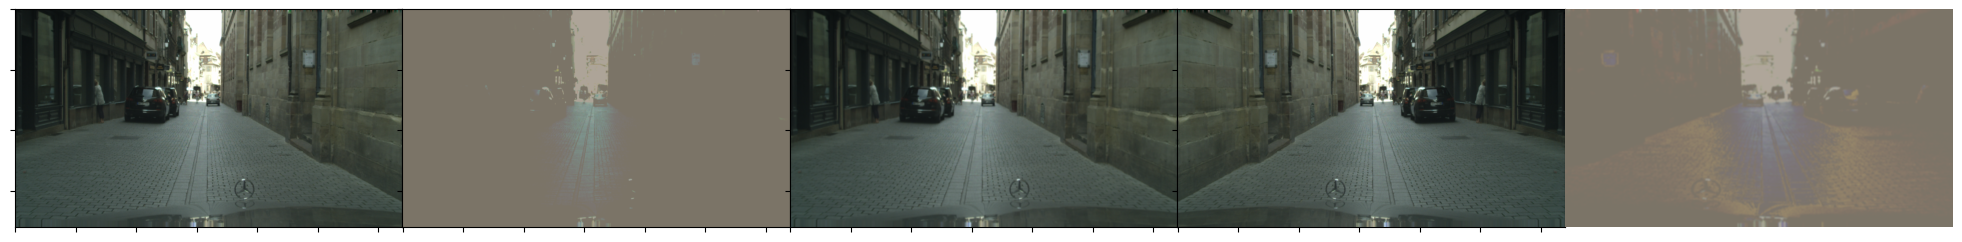

In [40]:
# Function to denormalize image for visualization
def denormalize(image):
    image = image.to('cpu').numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

cj = A.Compose([
    A.Resize(512, 1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
    A.Resize(720, 1280),
    ToTensorV2()
])

gb = A.Compose([
    A.Resize(512, 1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.GaussianBlur((3, 7), sigma_limit=(0.1, 5), p=1),
    A.Resize(720, 1280),
    ToTensorV2()
])

hf = A.Compose([
    A.Resize(512, 1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.HorizontalFlip(p=1),
    A.Resize(720, 1280),
    ToTensorV2()
])

all = A.Compose([
    A.Resize(512, 1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.HorizontalFlip(p=1),
    #A.VerticalFlip(p=0.5),
    A.RandomResizedCrop(height=512, width=1024, scale=(0.8, 1.0)),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
    A.GaussianBlur((3, 7), sigma_limit=(0.1, 5), p=1),
    A.Resize(720, 1280),
    ToTensorV2()
])

notrans = A.Compose([
    A.Resize(512, 1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.Resize(720, 1280),
    ToTensorV2()
])


fig, axes = plt.subplots(1, 5, figsize=(25, 6))
for idx, transform in enumerate([notrans, cj, gb, hf, all]):
  dataset = Cityscapes(root_dir=cityscape_dataset_path, split='train', transforms=transform)
  dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)
  _, inputs = next(enumerate(dataloader))
  img = inputs[0][0].squeeze()
  print(img.shape)
  axes[idx].imshow(denormalize(img), cmap="Greys")
  axes[idx].set_xticklabels([])
  axes[idx].set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
plt.savefig("./cityscapes_transforms.png", format="png")